# Introduction

* Testing 1D NODE-URANS model and comparing with true data
* **NOTE**: For modeling energies

In [1]:
# import all python, pytorch, and ML libraries, classes and functions
from NN_funcs import *
from scipy.integrate import odeint

# inport plotting routines
import matplotlib.pyplot as plt
import plotting as plots

# Start main

## Set parameters

In [2]:
# Data type
casenum       = [1]       # dataset case number(s) (see DataAcqu_LSTM.ipynb or data_funcs.py)
casenum_test  = [1]          # case to be tested
# parameters used for data acquisition
target_T        = 1          # target time period for sampling frequency
seq_len_T       = 64         # target sequence length (sampling frequency) of LSTM input for target_T
dt_target       = target_T/seq_len_T

normEnergy    = True         # normalize energy
interpIO      = True         # interpolate data
set_dt_seq    = True         # set dt for `interpIO` such that time length of `seq_len` data points = 1 time period
dt_T          = 1.0          # dt for interpIO
if set_dt_seq:
    seq_len     = int(dt_T/dt_target)  # sequence length (lag time) for LSTM input
else:
    seq_len     = seq_len_T            # sequence length (lag time) for LSTM input

if seq_len==1:
    raise Exception(f'Need more than 1 elements in the sequence for integration. '\
                    f'Current: seq_len_T={seq_len_T}, dt_T={dt_T}, seq_len={seq_len}. Exiting...')

add_IP_case   = 0            # cases determining the additional inputs case 0: no additional inputs; case 1: time; case 2: time, ke, pe
add_IP_time   = False           # add time info as an additional input
add_IP_ke_pe_T= False           # add ke and pe decay time scales as additional inputs (make sure the IPs are normalized)
add_IP_Fr_Gn  = False           # add Frh and Gn as additional inputs

Ntrainper     = 0.9             # number of training data (%)

# Hyperparameters (from training)
# data
n_val         = 0.1          # validation data (ratio)
n_inputs      = 4            # number of inputs
n_outputs     = 4            # number of outputs
# network architecture
model_name    = 'NODE_MLP'       # model name: 'SingleMLP' 'ResNet' 'DenseNet' 'LSTM' 'NODE_MLP'
NODE_method   = 'rk4'         # ODE solver in NODE model
NODE_rtol     = 1e-3         # relative tolerance in NODE
NODE_atol     = 1e-4         # absolute tolerance in NODE
# dense layers
n_per_layer   = 40           # number of neurons on all hidden dense layers (manually update model if needed)
n_layers      = 10            # number of dense layers - ResNet, DenseNet
drp_in        = 0            # probability value for input dropout 
drp_hd        = 0            # probability value for hidden layer dropout
# other settings
lkyReLU_alpha = 0.1          # slope of leakyReLU
lrate         = 5e-2         # learning rate
gamma         = 0.99         # for learning rate scheduler
# training parameters
nepoch        = 10         # number of training epochs (additional for restart runs)
batch_size    = 100          # batch size
scaleData     = False        # scale data (e.g.: naive min-max scaling of I/O)
plot_itr      = False         # plot training curves and testing
plot_epoch    = 200          # epoch interval for plotting
# restart NN model
restartTrain  = False        # restart training
ensmbleTrain  = False        # restart training with ensemble (first restart training for a few epoch and figure out ensm_errval)
ensmb_errval  = 1.7e-6       # models with error below this will be used for ensemble. Choose manually based on original training curve
nepoch_in     = 4000         # nepoch of original (old) model
lrate_restart = 5e-4         # new lrate

# Device settings
disable_cuda  = True        # disable GPU?

# Model evaluation regime (in NN training or testing data regimes)
eval_regime   = 'training'   # training testing
tin_offset    = 0            # time offset from initial time of the evaluation regime
# settings for time integration
tin_add       = 10            # amount of time after tin: tfi = tin + tin_add   (29.4,  20)
dt            = 0            # time step for ODE solver. Use dt = 0 for time data from training samples. (0.064, 0.016)

# Save figures & output data
saveFig       = False         # save figure(s) or not
saveData      = False        # save data of plots for full plotting

In [3]:
# get casenames
casename     = [get_casename(i) for i in casenum]

# model filename
modelfname = f'SSTRANS_EnergyEqn_normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
                f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum)):              # casename(s)
    modelfname = f'{modelfname}_{casename[i]}'
modelfname_full = f'{modelfname}_PyTModel_{model_name}_seqlen{seq_len}_'\
                f'nMLPLayers{n_layers}_nNeurons{n_per_layer}_batch{batch_size}_lr{lrate}_'\
                f'scaleData{scaleData}_nin{n_inputs}_Ntrain{Ntrainper}'
if ensmbleTrain or restartTrain:           # restart filename
    modelfname_full = f'{modelfname_full}_nepoch{nepoch_in}'
    lrate        = lrate_restart
    saveFnameRes =f'_restartEpoch{nepoch_in}_lr{lrate}'
else:
    modelfname_full = f'{modelfname_full}_nepoch{nepoch}'
savefilename = f'Data_models/{modelfname_full}'

# testing data filename
# get casenames
casename     = [get_casename(i) for i in casenum_test]
shuffledata  = False             # randomly shuffle training data or not
loaddatapath = f'Data_training/RANSdata_shuffle{shuffledata}_in-Energy_NODE_seqlen{seq_len}_'\
            f'normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
            f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum_test)):    # casename(s)
    loaddatapath = f'{loaddatapath}_{casename[i]}'
loaddatapath = f'{loaddatapath}_Ntrain{Ntrainper}.npz'

# figure & output data filenames
fnameOP      = f'Out_{modelfname_full[18:]}_ODE_testdata'
for i in range(len(casenum_test)):    # casename(s)
    fnameOP = f'{fnameOP}_{casename[i]}'
fnameOP      = f'{fnameOP}_tout{tin_add}_toff{tin_offset}'
fnameFig     = f'Figs/{fnameOP}.png'
fnameData    = f'Data_models/{fnameOP}.npz'

# ============cuda settings============
if not disable_cuda and torch.cuda.is_available():
    device_name = torch.device('cuda')
else:
    device_name = torch.device('cpu')
print(f'Using the device: {device_name}')

Using the device: cpu


## Load data

### Load unshuffled data from training (& testing) - scale data if necessary

In [4]:
npzfile = np.load(loaddatapath)
# !!!!!!!Make sure the datatype is float!!!!!!
nntrain_IP   = npzfile['datatrain_IP'].astype('float32')
nntrain_OP   = npzfile['datatrain_OP'].astype('float32')
nntrain_dydt   = npzfile['datatrain_dydt'].astype('float32')
nntrain_time = npzfile['datatrain_time'].astype('float32')
t            = npzfile['data_time'].astype('float32')
nu           = npzfile['nu']
drhobardz    = npzfile['drhobardz']
accel        = npzfile['accel']
rho0         = npzfile['rho0']
Nfreq        = np.sqrt( -(accel/rho0) * drhobardz )

# Test data is 30% of full data (to change use `DataAcqu*` code)
nntest_IP    = npzfile['datatest_IP'].astype('float32')
nntest_OP    = npzfile['datatest_OP'].astype('float32')
nntest_dydt   = npzfile['datatest_dydt'].astype('float32')
nntest_time  = npzfile['datatest_time']

# varnames and time data for plotting
data_ip_varnames  = npzfile['data_ip_varnames']
data_dy_varnames  = npzfile['data_dy_varnames']

print(f'Number of samples for training:\t{nntrain_IP.shape[0]}')
print(f'Number of samples for testing:\t{nntest_IP.shape[0]}')

if n_inputs != nntrain_IP.shape[-1]:
    raise Exception(f'n_inputs ({n_inputs:,}) ~= # input of training samples from data ({nntrain_IP.shape[-1]:,})')

if normEnergy:
    totalEt0 = npzfile['totalE'][0]

Number of samples for training:	1671
Number of samples for testing:	186


### Select which regime to evaluate model (training or testing regime)

In [5]:
# NOTE: Use scaled data for ODE solver, else, each variable might need separate dt for stability
if eval_regime == 'testing':
    test_data = nntest_IP 
    test_OP   = nntest_dydt[:,0,:]
    test_time = nntest_time[:,0]
elif eval_regime == 'training':
    test_data = np.append(nntrain_IP, nntest_IP, axis=0) # nntrain_IP
    test_OP   = np.append(nntrain_dydt[:,0,:], nntest_dydt[:,0,:], axis=0) # nntrain_dydt[:,0,:]
    test_time = np.append(nntrain_time[:,0], nntest_time[:,0], axis=0) # nntrain_time[:,0]
    
# if evaluation is done after an offset from starting time of each regime
if tin_offset>0:
    tstart = test_time[0] + tin_offset
    tempID = np.where( test_time>tstart)[0]
    if len(tempID)>2:
        print(f'Adding {tin_offset} offset to initial time for evaluation.\nOld inital time:\t{test_time[0]}\nNew initial time:\t{tstart}')
        test_time = test_time[tempID]
        test_data = test_data[tempID,:]
        test_OP   = test_OP[tempID,:]
    else:
        print(f'Offset ({tstart}) is above last time entry of data available [{test_time[0]}, {test_time[-1]}] OR not enough data left after offset ({len(tempID)}). Reduce offset time!')

## Converting from q to E (if needed)

In [6]:
if normEnergy:
    E_true = test_data.copy()
else:
    E_true = test_data.copy()
    for i in range(test_data.shape[0]):
        E_true[i,:] = convert_q_E(test_data[i,:], Nfreq)
    print(f'Energy converted from q')
dEdt_true = np.gradient(E_true[:,:], test_time, edge_order=2, axis=0)

## Define & Load the network

In [7]:
# original model
model = defNNmodel(model_name, n_inputs=n_inputs, n_outputs=n_outputs, n_layers=n_layers, 
                  n_per_layer=n_per_layer, device_name=device_name)
# load model
modelpath = savefilename+'_restart.tar'
checkpoint = torch.load(modelpath)
epoch_history = checkpoint['epoch_history']
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
lrate_history = checkpoint['lrate_history']
NODE_method = checkpoint['NODE_method']
NODE_rtol = checkpoint['NODE_rtol']
NODE_atol = checkpoint['NODE_atol']
loss_func = checkpoint['loss_func']
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

MLP with number of parameters =  15124


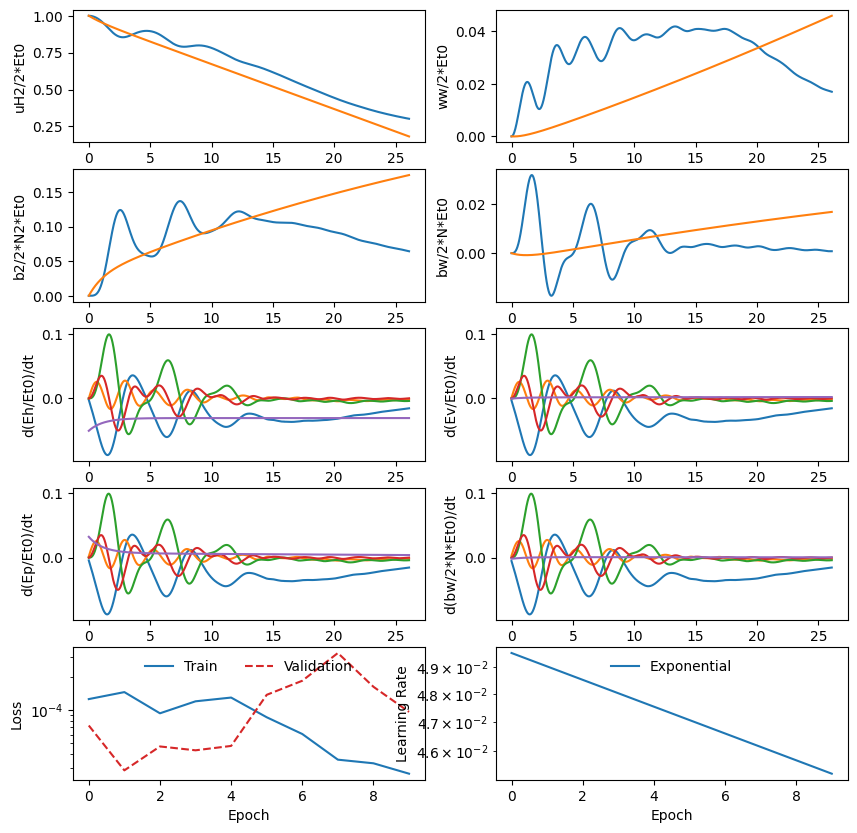

In [8]:
# test model with sample data
temptin = 0
# testing data for plotting
test_t = torch.from_numpy(nntrain_time[temptin:,0])
test_y0 = torch.from_numpy(nntrain_IP[temptin,:])
# ODE solver solution for comparison
test_true_y = torch.from_numpy(nntrain_OP[temptin:,0,:])
test_true_dy = torch.from_numpy(nntrain_dydt[temptin:,:])

model.to(device_name)
with torch.no_grad():
    _, pred_y, pred_dy = evaluate_NODE_model(model, NODE_method, NODE_rtol, NODE_atol, test_y0, test_t, test_true_y, loss_func)
    args = test_t.cpu(), test_t.cpu(), test_true_y.cpu(), pred_y.cpu(), data_ip_varnames, test_true_dy.cpu(), pred_dy.cpu(), data_dy_varnames, \
            epoch_history, train_loss_history, val_loss_history, lrate_history
    plots.plot_train('RANS',args)
    plt.show()

## Time integrate using NODE

In [9]:
# Initial condition
q0   = E_true[0,:]
# time step for ODE
if dt==0:
    dt   = np.min(np.diff(test_time))
else:
    print(f"NOTE: Data dt = {np.min(np.diff(test_time))}. Chosen dt = {dt}")
# time data
tin  = test_time[0]
tfi  = tin + tin_add
t    = np.arange(tin, tfi, dt)

# q from true RHS - to validate ODE solver
finterp = interpolate.interp1d(test_time, test_OP, axis=0, kind='cubic', fill_value="extrapolate")
dq_true = finterp(t)
# true rhs of dqdt using data (from gradient of data)
def rhsRANStrue(q, t, interpmodel):
    # interpolate at t
    dqdt = interpmodel(t)
    return dqdt   # output in vector format
tic = time.time()
q_true = odeint(rhsRANStrue, q0, t, args=(finterp,))
elpsdt = time.time() - tic
print(f'Time elapsed for true RHS: {int(elpsdt/60)} min {elpsdt%60:.2f} sec')

# q from NN model - time integrate using RHS = NN model
tic = time.time()

with torch.no_grad():
    _, q_ML, dq_ML = evaluate_NODE_model(model, NODE_method, NODE_rtol, NODE_atol, 
                                         torch.from_numpy(q0), torch.from_numpy(t), torch.from_numpy(q_true), loss_func)
elpsdt = time.time() - tic
print(f'Time elapsed for NN RHS: {int(elpsdt/60)} min {elpsdt%60:.2f} sec')
q_ML = q_ML.detach().cpu().numpy()
dq_ML = dq_ML.detach().cpu().numpy()

Time elapsed for true RHS: 0 min 0.00 sec
Time elapsed for NN RHS: 0 min 0.17 sec


## Plot results

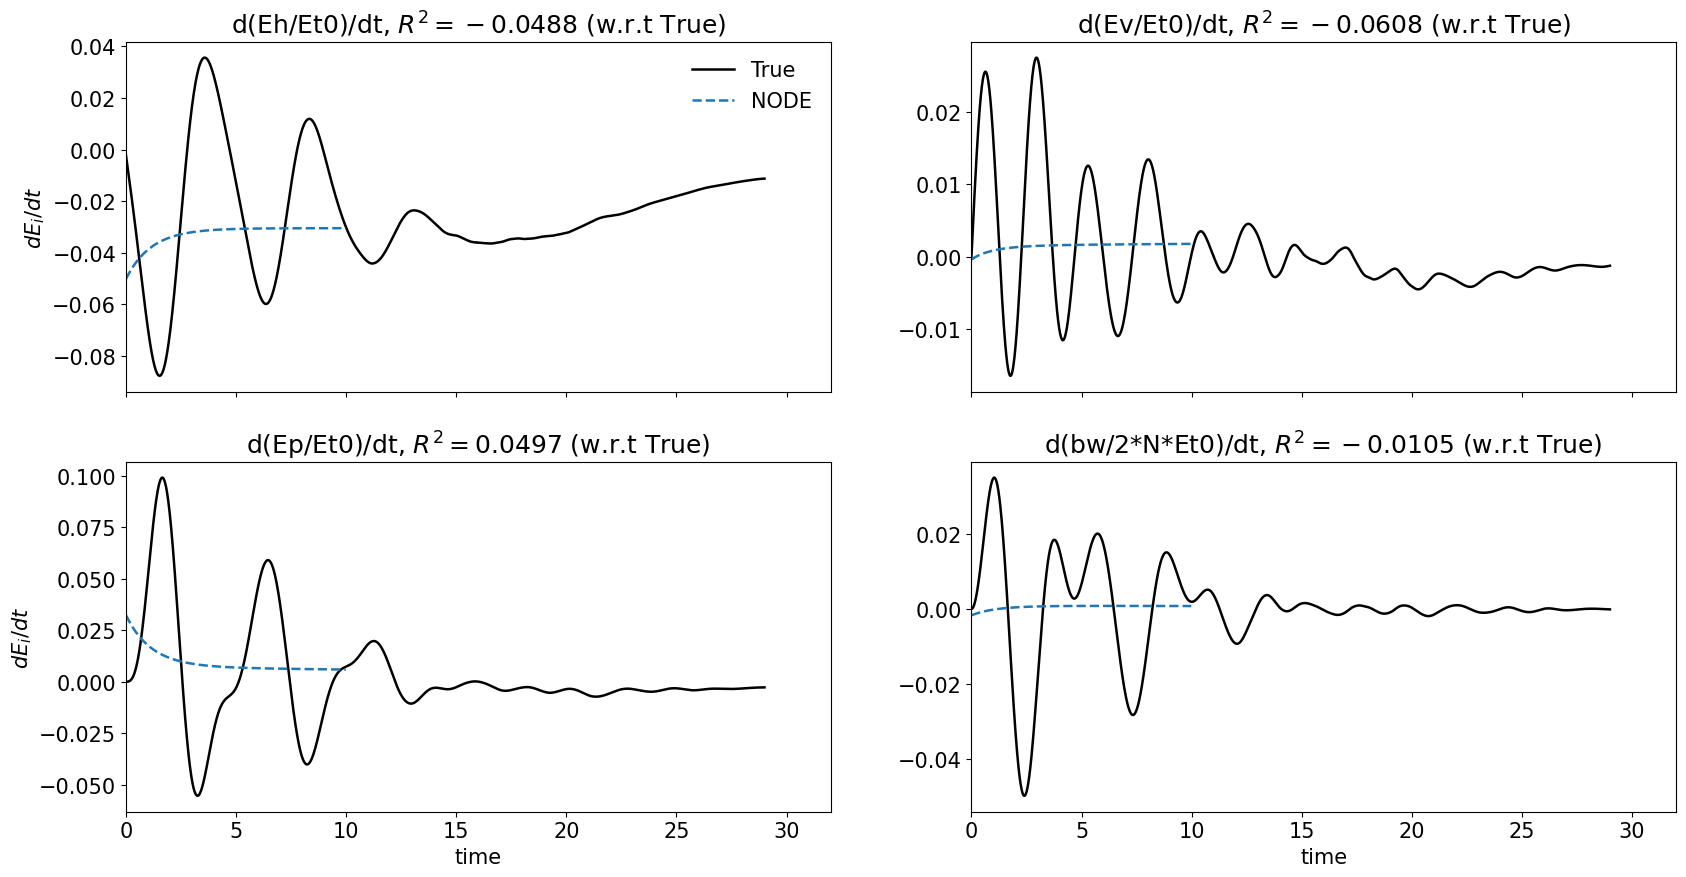

In [10]:
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(2,2,figsize=(20,10),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(n_outputs):
    axs[i].plot(test_time,dEdt_true[:,i],'-', color='black', linewidth=1.8, label='True')
    # axs[i].plot(t,dq_true[:,i],'--', color='tab:red', label='using true RHS')
    axs[i].plot(t,dq_ML[:,i],'--', color='tab:blue', linewidth=1.8, label='NODE')
    tempID = [t[:]<test_time[-1]][0]
    r2 = metrics.r2_score(dq_true[tempID,i], dq_ML[tempID,i])
    axs[i].set_title(f'{data_dy_varnames[i]}, $R^2 = {r2:0.3}$ (w.r.t True)')
    axs[i].set_xlim([t[0], t[-1]])
    axs[i].set_xlim([t[0], 32])
axs[2].set_xlabel(r'time'); axs[3].set_xlabel(r'time')
axs[0].set_ylabel(r'$dE_i/dt$')
axs[2].set_ylabel(r'$dE_i/dt$')
axs[0].legend(frameon=False);

=============Data not saved=============


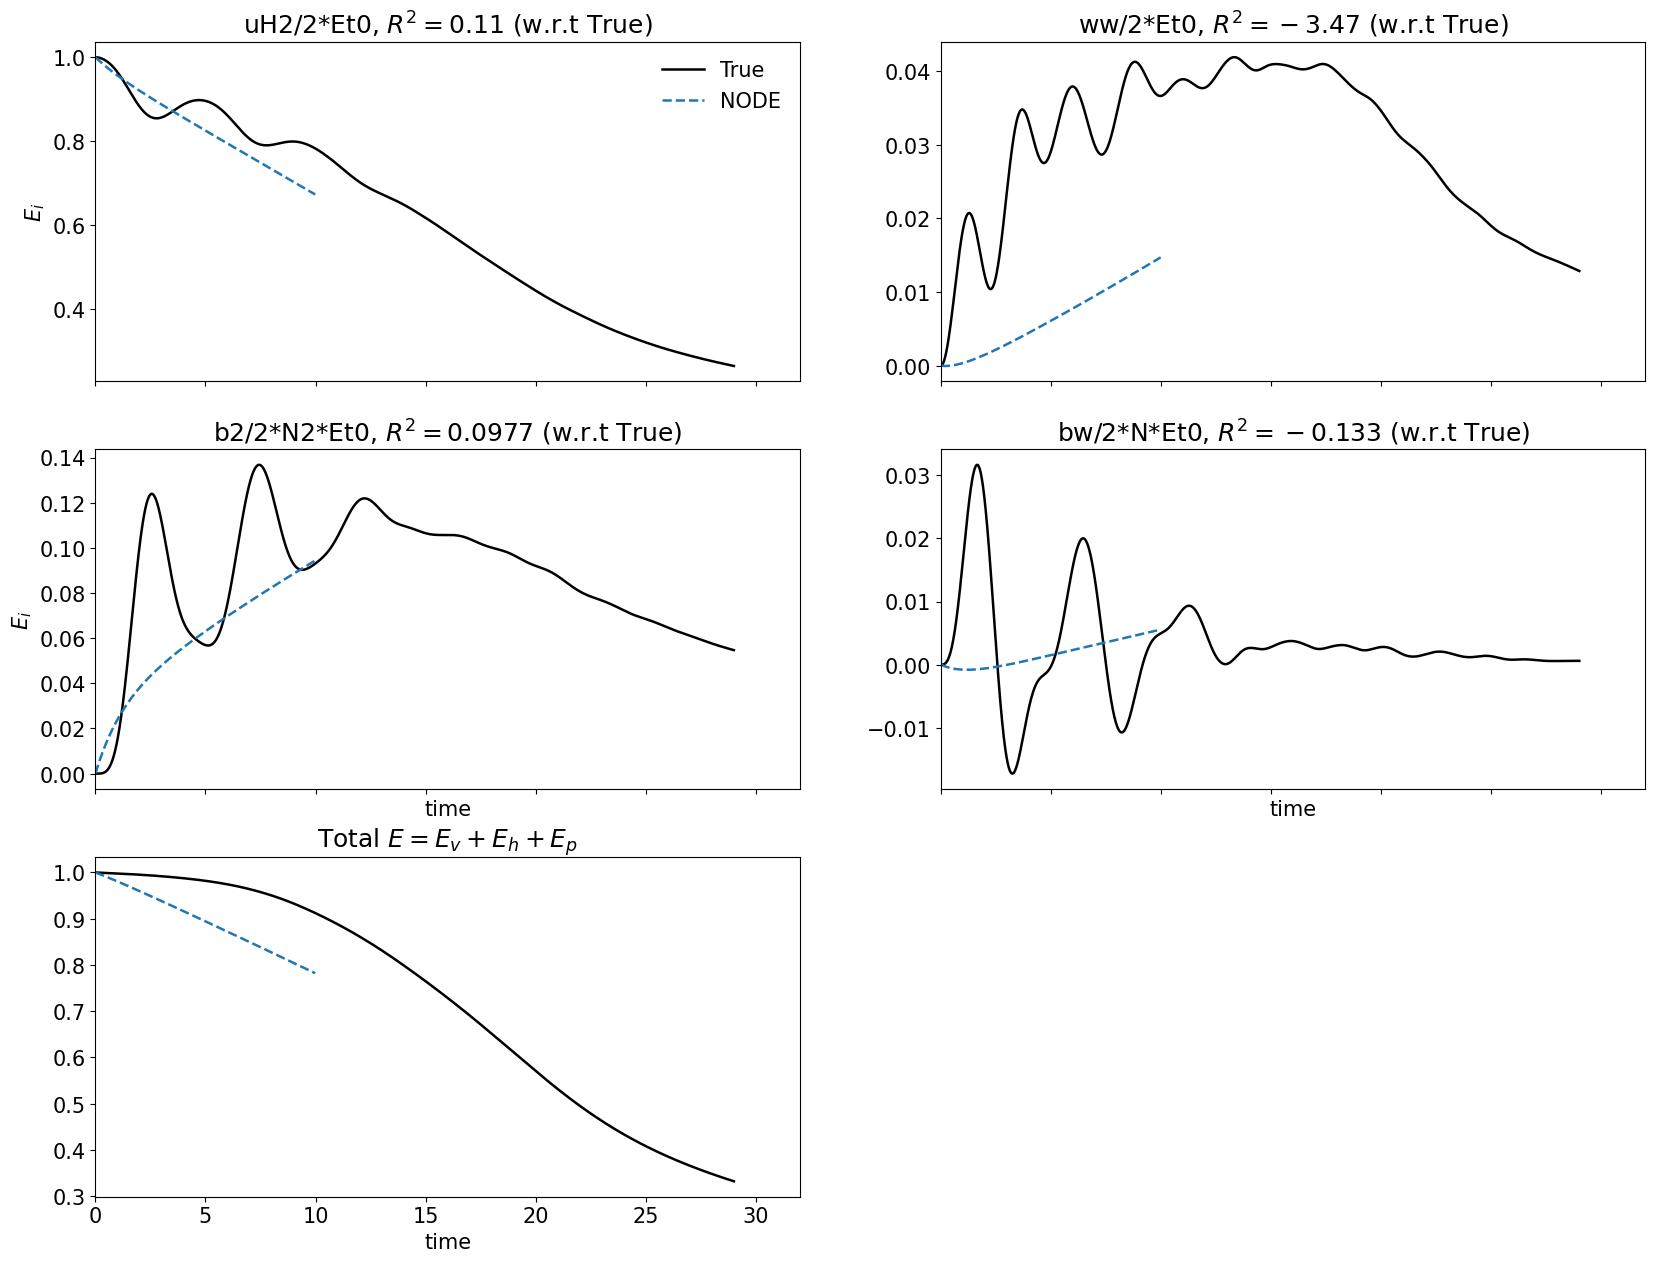

In [11]:
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3,2,figsize=(20,15),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(n_outputs):
    axs[i].plot(test_time,E_true[:,i],'-', color='black', linewidth=1.8, label='True')
    # axs[i].plot(t,q_true[:,i],'--', color='tab:red', label='using true RHS')
    axs[i].plot(t,q_ML[:,i],'--', color='tab:blue', linewidth=1.8, label='NODE')
    tempID = [t[:]<test_time[-1]][0]
    r2 = metrics.r2_score(q_true[tempID,i], q_ML[tempID,i])
    axs[i].set_title(f'{data_ip_varnames[i]}, $R^2 = {r2:0.3}$ (w.r.t True)')
    axs[i].set_xlim([t[0], t[-1]])
    axs[i].set_xlim([t[0], 32])
axs[2].set_xlabel(r'time'); axs[3].set_xlabel(r'time')
axs[0].set_ylabel(r'$E_i$')
axs[2].set_ylabel(r'$E_i$')
axs[0].legend(frameon=False);

totalE = np.sum(E_true[:,0:3], axis=1)
totalE_qtrue = np.sum(q_true[:,0:3], axis=1)
axs[4].plot(test_time, totalE, '-', color='black', linewidth=1.8, label='True')
# axs[4].plot(t, totalE_qtrue, '--', color='tab:red', linewidth=1.8, label='using true RHS')
totalE_ML = np.sum(q_ML[:,0:3], axis=1)
axs[4].plot(t, totalE_ML, '--', color='tab:blue', linewidth=1.8, label='NN')
axs[4].set_xlabel(r'time')
axs[4].set_title(r'Total $E = E_v + E_h + E_p$');
axs[-1].axis('off')

if saveFig: plt.savefig(fnameFig, bbox_inches='tight') #,dpi=100)

if saveData:
    np.savez(fnameData,
             test_time=test_time, q_true=E_true[:,:],
             t=t, q_ODE=q_true, q_ML=q_ML, dq_ODE=dq_true, dq_ML=dq_ML, totalEt0=totalEt0, Nfreq=Nfreq,
             data_ip_varnames=data_ip_varnames, data_dy_varnames=data_dy_varnames)
    print('=============Save data=============')
else:
    print('=============Data not saved=============')